# Facial Emotion Detection System

## 1. Imports and Setup

In [8]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
try:
    # Disable scientific notation for clarity
    np.set_printoptions(suppress=True)
except:
    pass

Num GPUs Available:  0


## 2. Data Preprocessing

In [9]:
def load_fer2013(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}. Please place 'fer2013.csv' in the 'data' folder.")
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    # Filter out 'Disgust' (1)
    # Map: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    data = data[data['emotion'] != 1].copy()
    
    # Remap labels to 0-5
    # New: 0=Angry, 1=Fear, 2=Happy, 3=Sad, 4=Surprise, 5=Neutral
    label_map = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
    data['emotion'] = data['emotion'].map(label_map)
    
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        faces.append(face.astype('float32'))
    
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1) # (N, 48, 48, 1)
    
    # Normalize
    faces /= 255.0
    
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions

# Load Data
DATA_PATH = 'data/fer2013.csv'
try:
    print("Loading data...")
    raw_data = load_fer2013(DATA_PATH)
    print("Preprocessing data...")
    X, y = preprocess_data(raw_data)
    
    # Split 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    print(f"Input Shape: {X_train.shape[1:]}")
except Exception as e:
    print(f"Error: {e}")

Loading data...
Preprocessing data...
Training samples: 28272
Testing samples: 7068
Input Shape: (48, 48, 1)


## 3. Model Definition

In [10]:
def build_model(input_shape=(48, 48, 1), num_classes=6):
    model = Sequential()

    # 1st Convolution Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution Block
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution Block
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution Block
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

d:\RUSL\Third Year\my\ICT3212 - Introduction to Intelligent Systems\Project\Facial Emotion Detection System\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,478,214 (17.08 MB)

 Trainable params: 4,474,246 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

## 4. Model Training

In [11]:
BATCH_SIZE = 64
EPOCHS = 30  # Adjust as needed (e.g., 50)

# Callbacks
if not os.path.exists('Models'):
    os.makedirs('Models')

checkpoint = ModelCheckpoint('Models/emotion_model_nb.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

callbacks_list = [checkpoint, reduce_lr, early_stop]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=True
)

model.save('Models/emotion_model_final_nb.keras')

Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.1899 - loss: 2.7369
Epoch 1: val_accuracy improved from None to 0.17289, saving model to Models/emotion_model_nb.keras

Epoch 1: finished saving model to Models/emotion_model_nb.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 312s 691ms/step - accuracy: 0.2044 - loss: 2.5814 - val_accuracy: 0.1729 - val_loss: 2.3776 - learning_rate: 1.0000e-04
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.2262 - loss: 2.3308
Epoch 2: val_accuracy improved from 0.17289 to 0.30065, saving model to Models/emotion_model_nb.keras

Epoch 2: finished saving model to Models/emotion_model_nb.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 334s 756ms/step - accuracy: 0.2310 - loss: 2.2830 - val_accuracy: 0.3007 - val_loss: 1.7429 - learning_rate: 1.0000e-04
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.2480 - loss: 2.1714
Epoch 3: val_accuracy improved from 0.30065 to 0.33390, saving model to Models/emotion_model_nb.keras

Epoc

## 5. Evaluation

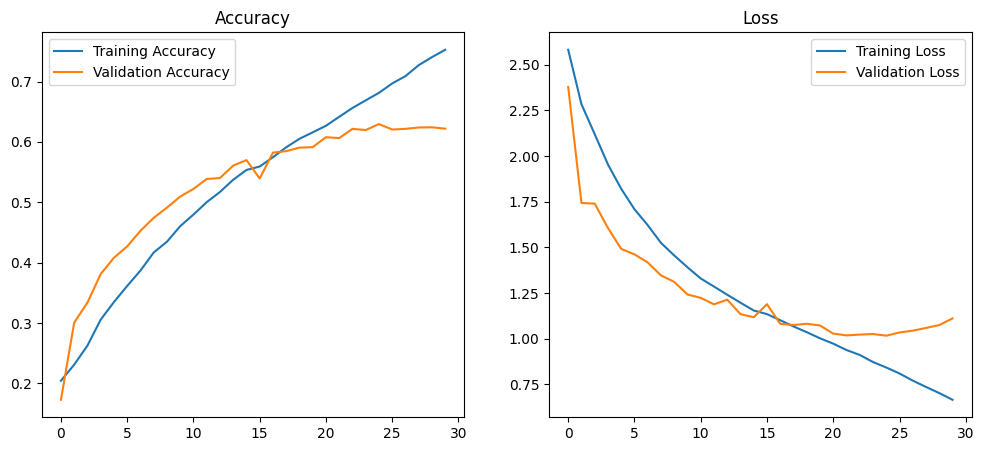

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

## 6. Real-Time Detection (Webcam)
Run the following cell to start the webcam. Press **'q'** to quit the window.

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model (ensure this path matches where you saved it)
model = load_model('Models/emotion_model_final_nb.keras')

# Emotion Labels
EMOTION_LABELS = {0: 'Anger', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

# Load Face Cascade
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

# Start Webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Could not open webcam")
else:
    print("Webcam started. Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Mirror image
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        
        for (x, y, w, h) in faces:
            # Preprocess face
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            roi_gray = roi_gray.astype('float32') / 255.0
            roi_gray = np.expand_dims(roi_gray, axis=0)
            roi_gray = np.expand_dims(roi_gray, axis=-1)
            
            # Predict
            prediction = model.predict(roi_gray, verbose=0)
            max_index = int(np.argmax(prediction))
            label = EMOTION_LABELS[max_index]
            confidence = prediction[0][max_index]
            
            # Draw
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} ({confidence:.2f})", (x, y-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        cv2.imshow('Facial Emotion Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

Webcam started. Press 'q' to quit.
